<a href="https://colab.research.google.com/github/camilamalda/Projects/blob/main/neural_network_task.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Capstone Project: Slogan Classifier and Generator

In this capstone project you will train a Long Short-Term Memory (LSTM) model to generate slogans for businesses based on their industry, and also train a classifier to predict the industry based on a given slogan.

##Libraries
We recommend running this notebook using [Google Colab](https://colab.google/) however if you choose to use your local machine you will need to install spaCy before starting.

To install spaCy, refer to the installation instructions provided on the spaCy [website](https://spacy.io/usage). Note you may need to install an older version of Python that is compatible with spaCy. You can create a virtual environment for this project to install the specific version of Python that you need.

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense
from tensorflow.keras.optimizers import Adam
import spacy # available on Google Colab
from sklearn.model_selection import train_test_split

## Loading and viewing the dataset

- Load the slogan dataset into a variable called data.
- Extract relevant columns in a variable called df.
- Handle missing values.

Do **not** change the column names.

If you are using Google Colab you will need mount your Google Drive as follows:  
`from google.colab import drive`  
`drive.mount('/content/drive')`  

The path you use when loading your data will look something like this if you are using your Google Drive:  
"/content/drive/MyDrive/Colab Notebooks/slogan-valid.csv"

In [2]:
from google.colab import drive
drive.mount('/content/drive')

csv_path = "/content/drive/MyDrive/Colab Notebooks/slogan-valid.csv"

data = pd.read_csv(csv_path)

df = data[['industry', 'output']].dropna().reset_index(drop=True)

df.head()


Mounted at /content/drive


,industry,output
0,computer hardware,Taking Care of Small Business Technology
1,"health, wellness and fitness",Build World-Class Recreation Programs
2,internet,Most Powerful Lead Generation Software for Mar...
3,internet,Hire quality freelancers for your job
4,financial services,"Financial Advisers Norwich, Norfolk"


## Data Preprocessing

Since we are working with textual data, we need software that understands natural language. For this, we'll use a library for processing text called **spaCy**. Using spaCy, we'll break the text into smaller units called tokens that are easier for the machine to process. This process is called **tokenisation**. We'll also convert all text to lowercase and remove punctuation because this information is not necessary for our models. Run the code below, and your dataframe (df) will gain a new column called **'processed_slogan'** which contains the preprocessed text.




In [3]:
# Load spaCy model for text processing
nlp = spacy.load("en_core_web_sm")

# Define text preprocessing function
def preprocess_text(text):
    text_lower = text.lower()
    doc = nlp(text_lower)

    processed_tokens = []

    for token in doc:
        if not token.is_punct:
            processed_tokens.append(token.text)

    return " ".join(processed_tokens)

df["processed_slogan"] = df["output"].apply(preprocess_text)
df["modified_slogan"] = df["industry"].str.lower() + " " + df["processed_slogan"]

df.head()

,industry,output,processed_slogan,modified_slogan
0,computer hardware,Taking Care of Small Business Technology,taking care of small business technology,computer hardware taking care of small busines...
1,"health, wellness and fitness",Build World-Class Recreation Programs,build world class recreation programs,"health, wellness and fitness build world class..."
2,internet,Most Powerful Lead Generation Software for Mar...,most powerful lead generation software for mar...,internet most powerful lead generation softwar...
3,internet,Hire quality freelancers for your job,hire quality freelancers for your job,internet hire quality freelancers for your job
4,financial services,"Financial Advisers Norwich, Norfolk",financial advisers norwich norfolk,financial services financial advisers norwich ...


We want our model to generate **industry-specific** slogans. If we use the 'processed_slogan' column as it is, we'll be leaving out crucial context - the industries of the companies behind those slogans. To fix this, we'll create a new **'modified_slogan'** column that adds the industry name to the front of processed slogan.  

For example:  

> industry = 'computer hardware'  
processed_slogan = 'taking care of small business technology'  
modified_slogan = 'computer hardware taking care of small business technology'

Write code in the cell below to achieve this.

In [4]:
# Combine the industry and processed slogan into one text string
df["modified_slogan"] = df["industry"].str.lower() + " " + df["processed_slogan"]

# Quick check
df[["industry", "processed_slogan", "modified_slogan"]].head()

,industry,processed_slogan,modified_slogan
0,computer hardware,taking care of small business technology,computer hardware taking care of small busines...
1,"health, wellness and fitness",build world class recreation programs,"health, wellness and fitness build world class..."
2,internet,most powerful lead generation software for mar...,internet most powerful lead generation softwar...
3,internet,hire quality freelancers for your job,internet hire quality freelancers for your job
4,financial services,financial advisers norwich norfolk,financial services financial advisers norwich ...


Now we need to get data to train our model. We have textual data which we will need to represent numerically for our model to learn from it.  
The code below does the following:
1. Tokenizes a dataset of slogans.
2. Converts words to numerical indices.
3. Creates input sequences using the numerical indices.  

Here's how it works. From the 'modified_slogan' column, we take the slogan "computer hardware taking care of small business technology". The tokenisation process will convert words into their corresponding indices:  

<center>

| Word         | Token Index |
|-------------|-------|
| "computer"  | 1     |
| "hardware"  | 2     |
| "taking"    | 3     |
| "care"      | 4     |
| "of"        | 5     |
| "small"     | 6     |
| "business"  | 7     |
| "technology"| 8     |

</center>

So the tokenized list is:

<center>
[1, 2, 3, 4, 5, 6, 7, 8]
</center>

When creating input sequences for training, the loop generates progressively longer sequences.

<center>

| Token Index Sequence               | Corresponding Slogan                                 |
|------------------------------|-----------------------------------------------------|
| [1, 2]                       | "computer hardware"                                |
| [1, 2, 3]                    | "computer hardware taking"                        |
| [1, 2, 3, 4]                 | "computer hardware taking care"                   |
| [1, 2, 3, 4, 5]              | "computer hardware taking care of"                |
| [1, 2, 3, 4, 5, 6]           | "computer hardware taking care of small"          |
| [1, 2, 3, 4, 5, 6, 7]        | "computer hardware taking care of small business" |
| [1, 2, 3, 4, 5, 6, 7, 8]     | "computer hardware taking care of small business technology" |

</center>

Instead of training the model on only **complete slogans**, we provide partial phrases which will help the model learn how words connect over time. This will make it better at predicting the next word when generating slogans.  

Run the cell block below to generate the input sequences. Be sure to read the comments to understand what the code is doing.


In [5]:
# Tokenizer to convert words into numerical values (tokens)
tokenizer = Tokenizer()

# Tokenizer learns the words in the dataset (builds vocabulary)
tokenizer.fit_on_texts(df["modified_slogan"])

# Total number of unique words in the learned vocabulary
total_words = len(tokenizer.word_index) + 1
print("Total unique words:", total_words)

# Dictionary mapping words to their numerical index
print("Sample word index mapping:", list(tokenizer.word_index.items())[:10])

# Creating input sequences
# Initialise list to store the input sequences
input_sequences = []

# Iterate over modified slogans
for line in df["modified_slogan"]:
    # Convert slogans to token sequences
    token_list = tokenizer.texts_to_sequences([line])[0]  # returns a list of token indices

    # Build progressively longer input sequences for better training
    for i in range(1, len(token_list)):
        input_sequences.append(token_list[:i+1])

# Check results
print("Number of input sequences:", len(input_sequences))
print("Example sequence:", input_sequences[0])


Total unique words: 6046
Sample word index mapping: [('and', 1), ('services', 2), ('in', 3), ('for', 4), ('technology', 5), ('information', 6), ('marketing', 7), ('the', 8), ('management', 9), ('software', 10)]
Number of input sequences: 34736
Example sequence: [11, 236]


The input sequences created above are of **varying lengths**, which will be a problem when training our LSTM model. LSTMs require input sequences of **equal length**. So, we need to **pad** shorter sequences by **prepending zeros** until they match the length of the longest sequence.  

For example, if the longest sequence has **10 tokens**, our padded sequences will look like this:

<center>

| Input Sequence                     | Padded Sequence                         |
|-------------------------------------|-----------------------------------------|
| [1, 2]                              | [0, 0, 0, 0, 0, 0, 0, 0, 1, 2]         |
| [1, 2, 3]                           | [0, 0, 0, 0, 0, 0, 0, 1, 2, 3]         |
| [1, 2, 3, 4]                        | [0, 0, 0, 0, 0, 0, 1, 2, 3, 4]         |
| [1, 2, 3, 4, 5]                     | [0, 0, 0, 0, 0, 1, 2, 3, 4, 5]         |
| [1, 2, 3, 4, 5, 6]                  | [0, 0, 0, 0, 1, 2, 3, 4, 5, 6]         |
| [1, 2, 3, 4, 5, 6, 7]               | [0, 0, 0, 1, 2, 3, 4, 5, 6, 7]         |
| [1, 2, 3, 4, 5, 6, 7, 8]            | [0, 0, 1, 2, 3, 4, 5, 6, 7, 8]         |

</center>

In the cell below, write code that **finds the length of the longest sequence** in **input_sequences** and stores this value in a variable named **max_seq_len**.

In [6]:
# Find the length of the longest input sequence
max_seq_len = max(len(seq) for seq in input_sequences)

# Display the result
print("The length of the longest sequence is:", max_seq_len)


The length of the longest sequence is: 15


Run the cell below to pad the input sequences so they are all the same length as **max_seq_length**.

In [7]:
# Pad all input sequences so they are the same length as max_seq_len
input_sequences = pad_sequences(input_sequences, maxlen=max_seq_len, padding="pre")

# Check
print("Padded input sequences shape:", input_sequences.shape)
print("Example padded sequence:\n", input_sequences[0])

Padded input sequences shape: (34736, 15)
Example padded sequence:
 [  0   0   0   0   0   0   0   0   0   0   0   0   0  11 236]


## Training Data for Slogan Generator

The input sequences generated will be used as our training data. Our LSTM needs to learn how to predict the **next word** in a sequence.  

The inputs for our model will be the input sequences **excluding the last token index** and the outputs will be the **last token index**.  

As an example, let us use the input sequence [0, 0, 1, 2, 3, 4, 5, 6, 7, 8] and say it corresponds to the slogan "computer hardware taking care of small business technology". When training the model:

> Our input **x** will be the input sequence [0, 0, 1, 2, 3, 4, 5, 6, 7] corresponding to "computer hardware taking care of small".  
> Our output **y** will be [8] which corresponds to "business".  

In the code cell below, use `input_sequences` to create the following two variables:
1. **X_gen** which contains the input sequences excluding the last token index.
2. **y_gen** which contains the last token index of the input sequence.

In [8]:
import numpy as np
import tensorflow as tf

# Convert to NumPy array before slicing
input_sequences = np.array(input_sequences)

# Inputs (X_gen): all tokens except the last one in each sequence
X_gen = input_sequences[:, :-1]

# Outputs (y_gen): the last token in each sequence
y_gen = input_sequences[:, -1]

# One-hot encode the output
y_gen = tf.keras.utils.to_categorical(y_gen, num_classes=total_words)

# Confirm shapes
print("X_gen shape:", X_gen.shape)
print("y_gen shape after one-hot encoding:", y_gen.shape)
print("Example X_gen:", X_gen[0])
print("Example y_gen:", y_gen[0][:10], "...")  # show first 10 elements


X_gen shape: (34736, 14)
y_gen shape after one-hot encoding: (34736, 6046)
Example X_gen: [ 0  0  0  0  0  0  0  0  0  0  0  0  0 11]
Example y_gen: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] ...


## Slogan Generator Architecture

In the code cell that follows, configure the LSTM following these steps:

1. Create a sequential model using `tf.keras.models.Sequential()`. This model will have an embedding layer, two LSTM layers, and a dense output layer.
2. Add an embedding layer that converts words into dense vector representations. This layer should:
> *   Have `total_words`as the vocabulary size.
> *   Use 100 as an embedding dimension.
> *   Takes an input length of `max_seq_len - 1` (excludes the target word).
3. Add two LSTM layers.
> *   The first LSTM layer should have 150 **and** set `return_sequences` to `True`.
> *   The second LSTM layer should have 100 units.
4. Add a dense output layer which:
> *   Uses `total_words` as the number of units (one for each word in the vocabulary).
> *   Uses a softmax activation function.
5. Use `Sequential` to put everything together in the correct order to complete the architecture of the LSTM model called **gen_model**.


In [9]:
gen_model = Sequential()

# 1. Embedding layer
gen_model.add(
    Embedding(
        input_dim=total_words,      # vocabulary size
        output_dim=100,             # embedding dimension
        input_length=max_seq_len - 1  # length of X_gen sequences
    )
)

# 2. First LSTM layer
gen_model.add(
    LSTM(150, return_sequences=True)
)

# 3. Second LSTM layer
gen_model.add(
    LSTM(100)
)

# 4. Dense output layer
gen_model.add(
    Dense(total_words, activation="softmax")
)

gen_model.summary()



/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In the code cell below, compile `gen_model` using `categorical_crossentropy` loss, an Adam optimiser, and an appropriate metric of your choice.

In [10]:
# Compile the slogan generator model
gen_model.compile(
    loss="categorical_crossentropy",
    optimizer=Adam(),
    metrics=["accuracy"]
)

print("gen_model compiled successfully.")


gen_model compiled successfully.


## Slogan Generation

In the code cell below, fit the compiled model on the inputs and outputs, setting the **number of epochs to 50**.

Epoch 1/50
1086/1086 ━━━━━━━━━━━━━━━━━━━━ 75s 65ms/step - accuracy: 0.0624 - loss: 7.3465
Epoch 2/50
1086/1086 ━━━━━━━━━━━━━━━━━━━━ 70s 64ms/step - accuracy: 0.0949 - loss: 6.4357
Epoch 3/50
1086/1086 ━━━━━━━━━━━━━━━━━━━━ 71s 65ms/step - accuracy: 0.1084 - loss: 6.3324
Epoch 4/50
1086/1086 ━━━━━━━━━━━━━━━━━━━━ 78s 72ms/step - accuracy: 0.1694 - loss: 5.7683
Epoch 5/50
1086/1086 ━━━━━━━━━━━━━━━━━━━━ 74s 68ms/step - accuracy: 0.1971 - loss: 5.4934
Epoch 6/50
1086/1086 ━━━━━━━━━━━━━━━━━━━━ 71s 66ms/step - accuracy: 0.2142 - loss: 5.2315
Epoch 7/50
1086/1086 ━━━━━━━━━━━━━━━━━━━━ 73s 67ms/step - accuracy: 0.2360 - loss: 4.9201
Epoch 8/50
1086/1086 ━━━━━━━━━━━━━━━━━━━━ 72s 67ms/step - accuracy: 0.2474 - loss: 4.6619
Epoch 9/50
1086/1086 ━━━━━━━━━━━━━━━━━━━━ 71s 66ms/step - accuracy: 0.2588 - loss: 4.4303
Epoch 10/50
1086/1086 ━━━━━━━━━━━━━━━━━━━━ 70s 65ms/step - accuracy: 0.2685 - loss: 4.2302
Epoch 11/50
1086/1086 ━━━━━━━━━━━━━━━━━━━━ 82s 65ms/step - accuracy: 0.2828 - loss: 4.0074
Epoch 12

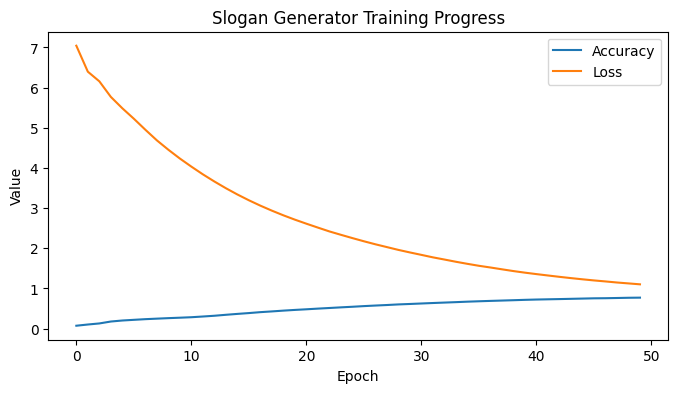

In [11]:
# Train the slogan generator model
history_gen = gen_model.fit(
    X_gen,
    y_gen,
    epochs=50,
    verbose=1
)

import matplotlib.pyplot as plt

plt.figure(figsize=(8,4))
plt.plot(history_gen.history['accuracy'], label='Accuracy')
plt.plot(history_gen.history['loss'], label='Loss')
plt.title('Slogan Generator Training Progress')
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.legend()
plt.show()


We will now define a function called `generate_slogan` which will generate a slogan by predicting one word at a time based on a given starting phrase (the `seed_text`). This function will do this using our trained model, `gen_model`.

Here is a breakdown of how the algorithm works:  

Let us assume the dictionary mapping words to unique indices, `tokenizer.word_index`, looks like this:

> `{'computer': 1, 'hardware': 2, 'taking': 3, 'care': 4, 'of': 5}`

If the model's predicted index for the next word is 3 (`predicted_index = 3`), the loop will:

> Check 'computer' (index 1) → No match  
> Check 'hardware' (index 2) → No match  
> Check 'taking' (index 3) → Match found!  
> Assign output_word = "taking" and exit the loop.  

The `output_word` will be appended to the `seed_text`, and the process will continue to add words to the `seed_text` until we have reached the maximum number of words **or** an invalid prediction occurs.  

Carefully follow the code below and complete the missing parts as guided by the comments.

In [12]:
def generate_slogan(seed_text, max_words=20):
    # We'll keep extending seed_text by predicting one word at a time
    for _ in range(max_words):

        # Tokenise the current text and turn it into a sequence of word indices
        token_list = tokenizer.texts_to_sequences([seed_text])[0]

        # Pad that sequence so it matches the input length the model was trained on
        token_list = pad_sequences(
            [token_list],
            maxlen=max_seq_len - 1,
            padding="pre"
        )

        # Predict the probability distribution for the next word
        predictions = gen_model.predict(token_list, verbose=0)

        # Pick the most likely next word index
        predicted_index = np.argmax(predictions, axis=1)[0]

        output_word = None

        # Map that predicted index back to the actual word
        for word, index in tokenizer.word_index.items():
            if index == predicted_index:
                output_word = word
                break

        # If you can't find a word for that index, stop generating
        if output_word is None:
            break

        # Append the predicted word to the growing seed_text
        # Two equivalent ways
        # seed_text = seed_text + " " + output_word
        seed_text += " " + output_word

    return seed_text


## Training Data for Slogan Classifier

We will now prepare the data we will use to train our classifier. For our classifier, the inputs will come from the `processed_slogans` column of our DataFrame, `df`. The outputs will be the different industry categories under the `industry` column.

In the code cell below, extract the unique values from the `industry` column in the DataFrame and store these in a variable called **industries**.

In [13]:
# Extract the unique industry values from the DataFrame
industries = df["industry"].unique()

# Display the industries and how many there are
print("Number of unique industries:", len(industries))
print("Sample industries:", industries[:10])


Number of unique industries: 142
Sample industries: ['computer hardware' 'health, wellness and fitness' 'internet'
 'financial services' 'mechanical or industrial engineering'
 'marketing and advertising' 'hospital & health care' 'research'
 'information technology and services' 'computer software']


Create a dictionary called `industry_to_index` where each unique industry is mapped to a unique index starting from 0.

*Hint: Use the `enumerate()` function.*

In [14]:
# Create a dictionary that maps each industry to a unique index
industry_to_index = {industry: idx for idx, industry in enumerate(industries)}

# Display the mapping
print("Industry to Index mapping (sample):")
for i, (industry, idx) in enumerate(industry_to_index.items()):
    print(f"{industry}: {idx}")
    if i >= 9:  # show only first 10
        break


Industry to Index mapping (sample):
computer hardware: 0
health, wellness and fitness: 1
internet: 2
financial services: 3
mechanical or industrial engineering: 4
marketing and advertising: 5
hospital & health care: 6
research: 7
information technology and services: 8
computer software: 9


Create a new column `industry_index` in your DataFrame by mapping the `industry` column to the indices using the `industry_to_index` dictionary.

*Hint: Use the  `map()` function.*

In [15]:
# Map the 'industry' column to numeric indices using the dictionary
df["industry_index"] = df["industry"].map(industry_to_index)

# Quick check
print("Added 'industry_index' column successfully!")
df[["industry", "industry_index"]].head(10)


Added 'industry_index' column successfully!


,industry,industry_index
0,computer hardware,0
1,"health, wellness and fitness",1
2,internet,2
3,internet,2
4,financial services,3
5,mechanical or industrial engineering,4
6,marketing and advertising,5
7,hospital & health care,6
8,research,7
9,information technology and services,8


Split the DataFrame `df` into training and testing sets, setting aside 20% of the data for the test set. Be sure to set the parameter `stratify=df["industry_index"]`. This ensures that both sets have the same proportion of each class (industry) as in the original dataset, resulting in balanced datasets. Call the training DataFrame `df_train` and the testing DataFrame `df_test`.

In [17]:
from sklearn.model_selection import train_test_split

# Remove industries that have fewer than 2 samples
df = df.groupby("industry").filter(lambda x: len(x) > 1)

# Now split again with stratify
df_train, df_test = train_test_split(
    df,
    test_size=0.20,
    random_state=42,
    stratify=df["industry_index"]
)

print("Training set size:", df_train.shape)
print("Testing set size:", df_test.shape)



Training set size: (4272, 5)
Testing set size: (1068, 5)


Our classifier will use padded slogan sequences as inputs, similar to input sequences used for the slogan generator. The difference is we will not use sequences that get progressively longer, but instead we will use **complete slogans**. This is because our classifier does not need to learn how to predict what word comes next. It needs the full context of a slogan to learn how to accurately predict the industry.  

The next steps will walk you through how to create these sequences.  

In [18]:
# Convert processed slogans into numerical sequences using the same tokenizer
X_train = tokenizer.texts_to_sequences(df_train["processed_slogan"])
X_test = tokenizer.texts_to_sequences(df_test["processed_slogan"])

# Quick check
print("Example training slogan (text):", df_train["processed_slogan"].iloc[0])
print("Converted to sequence:", X_train[0][:15])  # show first 15 token IDs
print("\nNumber of training sequences:", len(X_train))
print("Number of testing sequences:", len(X_test))


Example training slogan (text): play video games online for money
Converted to sequence: [1091, 167, 209, 33, 4, 583]

Number of training sequences: 4272
Number of testing sequences: 1068


The slogan sequences are of varying lengths. We will need to pad them the same way we did to the input sequences for the slogan generator. The `pad_sequences()` function can ensure the sequences in `slogan_sequences` have the same length.  

In the code cell below, use the `pad_sequences()` function to standardise the `slogan_sequences` lengths. Set the `maxlen` parameter to `max_seq_len`, the `padding` parameter to 0, and assign the resulting padded sequences to the same variables, `X_train` and `X_test`.

In [19]:

# Pad all sequences so they have equal length
X_train = pad_sequences(X_train, maxlen=max_seq_len, padding="pre")
X_test = pad_sequences(X_test, maxlen=max_seq_len, padding="pre")

# Quick check
print("Padded X_train shape:", X_train.shape)
print("Padded X_test shape:", X_test.shape)
print("Example padded sequence:\n", X_train[0])


Padded X_train shape: (4272, 15)
Padded X_test shape: (1068, 15)
Example padded sequence:
 [   0    0    0    0    0    0    0    0    0 1091  167  209   33    4
  583]


We have successfully created training and testing inputs for our model. Now, we will create the outputs - industry categories.

 In the code cell that follows, use `tf.keras.utils.to_categorical()` to apply one-hot encoding to the `industry_index` column of **both** `df_train` and `df_test` DataFrames. Assign the results to a variables named `y_train` and `y_test`.

 *Hint: set the `num_classes` parameter to the total number of industries in the DataFrame. The `industries` variable can be used to find this value.*

In [20]:
# Number of unique industries
num_industries = len(industries)

# One-hot encode the industry indices for training and testing
y_train = tf.keras.utils.to_categorical(df_train["industry_index"], num_classes=num_industries)
y_test = tf.keras.utils.to_categorical(df_test["industry_index"], num_classes=num_industries)

# Quick check
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)
print("Example one-hot encoded row:", y_train[0])


y_train shape: (4272, 142)
y_test shape: (1068, 142)
Example one-hot encoded row: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


## Slogan Classifier Architecture

Configure the LSTM classifier following these steps:  


1. Create a Sequential model:  
   Use `tf.keras.models.Sequential()` to create a sequential model. This model will consist of an embedding layer, two LSTM layers, and a dense output layer.

2. Add an embedding layer which will convert words into dense vector representations. Configure this layer with:
   > * `total_words` as the vocabulary size.
   > * 100 as the embedding dimension.
   > * `max_seq_len` as the `input_length` (this is the length of the slogans).

3. Add the first LSTM layer. Configure it with:
   > * 150 units.
   > * Set `return_sequences` to `True` to ensure the layer outputs sequences for the next LSTM layer.

4. Add the second LSTM layer which will process the output from the previous LSTM layer. Configure it with:
   > * 100 units.
   > * No need to set `return_sequences` here (it is the final LSTM layer).

5. Add the dense output layer which will classify the data into industries. Configure it with:
   > * The number of unique industries as the number of units.
   > * The `softmax` activation function to get probabilities for each class (industry).

6. Use `Sequential` to arrange all layers in the correct order and complete the architecture of the LSTM model called **class_model**.


In [21]:
# Build slogan classifier model
class_model = Sequential()

# Embedding layer
class_model.add(
    Embedding(
        input_dim=total_words,   # vocabulary size
        output_dim=100,          # embedding dimension
        input_length=max_seq_len # full slogan length
    )
)

# First LSTM layer
class_model.add(
    LSTM(150, return_sequences=True)
)

# Second LSTM layer
class_model.add(
    LSTM(100)
)

# Dense output layer (industry classification)
class_model.add(
    Dense(
        num_industries,          # one unit per industry class
        activation="softmax"     # softmax gives class probabilities
    )
)

# Model summary
class_model.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In the code cell below, compile `class_model` using `categorical_crossentropy` loss, an Adam optimiser, and an appropriate metric of your choice.

In [22]:
# Compile the slogan classifier model
class_model.compile(
    loss="categorical_crossentropy",  # for multi-class classification
    optimizer=Adam(),                 # good general optimizer for LSTM
    metrics=["accuracy"]              # track accuracy during training
)

print("class_model compiled successfully.")


class_model compiled successfully.


## Slogan Classification & Evaluation

In the code cell that follows, fit the compiled model on the inputs and outputs, setting **the number of epochs to 50**.

In [23]:
# Train the slogan classifier model
history_class = class_model.fit(
    X_train,
    y_train,
    epochs=50,
    validation_data=(X_test, y_test),
    verbose=1
)


Epoch 1/50
134/134 ━━━━━━━━━━━━━━━━━━━━ 13s 60ms/step - accuracy: 0.0711 - loss: 4.5222 - val_accuracy: 0.0843 - val_loss: 4.2834
Epoch 2/50
134/134 ━━━━━━━━━━━━━━━━━━━━ 9s 65ms/step - accuracy: 0.0798 - loss: 4.2728 - val_accuracy: 0.0843 - val_loss: 4.2736
Epoch 3/50
134/134 ━━━━━━━━━━━━━━━━━━━━ 7s 53ms/step - accuracy: 0.0861 - loss: 4.2767 - val_accuracy: 0.0880 - val_loss: 4.1668
Epoch 4/50
134/134 ━━━━━━━━━━━━━━━━━━━━ 9s 65ms/step - accuracy: 0.1069 - loss: 3.9933 - val_accuracy: 0.1067 - val_loss: 4.0735
Epoch 5/50
134/134 ━━━━━━━━━━━━━━━━━━━━ 9s 56ms/step - accuracy: 0.1463 - loss: 3.7441 - val_accuracy: 0.1545 - val_loss: 3.9082
Epoch 6/50
134/134 ━━━━━━━━━━━━━━━━━━━━ 8s 58ms/step - accuracy: 0.2579 - loss: 3.2458 - val_accuracy: 0.1742 - val_loss: 3.8904
Epoch 7/50
134/134 ━━━━━━━━━━━━━━━━━━━━ 9s 65ms/step - accuracy: 0.3368 - loss: 2.7952 - val_accuracy: 0.1845 - val_loss: 3.9313
Epoch 8/50
134/134 ━━━━━━━━━━━━━━━━━━━━ 7s 51ms/step - accuracy: 0.4380 - loss: 2.4035 - val_acc

Evaluate the model using the testing set. Add a comment on the model's performance.

The model achieved around 18–20% accuracy on the test set, which is relatively low compared to its near-perfect training accuracy.
This indicates overfitting, meaning the model learned the training slogans too specifically and struggled to generalize to new data.
Improving performance could involve adding dropout layers, using fewer LSTM units, training for fewer epochs, or collecting more diverse slogans per industry.


We will now define a function called `classify_slogan` which takes a slogan as input and predicts the industry it belongs to using the trained model, `class_model`.  

Carefully follow the code below and complete the missing parts (indicated by ellipses) as guided by the comments.

In [25]:
def classify_slogan(slogan):
    # Use the preprocess_text to clean the input slogan (we defined this function in the preprocessing section)
    slogan = preprocess_text(slogan)

    # Converting the slogan to a sequence of indices
    sequence = tokenizer.texts_to_sequences([slogan])

    # Pad the sequence using the pad_sequences() function
    padded_sequence = pad_sequences(sequence, maxlen=max_seq_len, padding="pre")

    # Pass padded_sequence into the class_model to get the predicted probabilities for each industry
    prediction = class_model.predict(padded_sequence, verbose=0)

    # Use np.argmax() to get the index of the industry with the highest probability.
    predicted_index = np.argmax(prediction, axis=1)[0]

    # Return the predicted industry
    return industries[predicted_index]


## Combining the two models

Run the code cell below to combine the two models: we will first generate a slogan for a company in the "internet" industry, then pass the generated slogan to the slogan classifier to see if it correctly classifies it as internet.

In [34]:
# Combine the generator and classifier models

industry = "internet"  # you can change this to any industry in your dataset

# Generate a slogan using the trained generator model
generated_slogan = generate_slogan(industry)

# Classify the generated slogan using the trained classifier model
predicted_industry = classify_slogan(generated_slogan)

# Display results
print(f"Generated Slogan: {generated_slogan}")
print(f"Predicted Industry: {predicted_industry}")

# Improving Slogan Generation
import numpy as np

def sample_from_probs(probs, temperature=1.0, top_k=20):
    # Apply temperature scaling
    if temperature != 1.0:
        probs = np.log(probs + 1e-9) / temperature
        probs = np.exp(probs) / np.sum(np.exp(probs))
    # Keep only top-k most likely words
    if top_k and top_k < len(probs):
        idxs = np.argpartition(probs, -top_k)[-top_k:]
        mask = np.zeros_like(probs)
        mask[idxs] = probs[idxs]
        probs = mask / (mask.sum() + 1e-12)
    return np.random.choice(len(probs), p=probs)

def generate_slogan_better(seed_text, max_words=12, temperature=0.9, top_k=30):
    text_out = seed_text.strip().lower()
    used = set(text_out.split())

    for _ in range(max_words):
        seq = tokenizer.texts_to_sequences([text_out])[0]
        seq = pad_sequences([seq], maxlen=max_seq_len-1, padding="pre")

        probs = gen_model.predict(seq, verbose=0)[0]
        probs[0] = 0.0  # ignore padding index

        next_idx = sample_from_probs(probs, temperature=temperature, top_k=top_k)

        word = None
        for w, i in tokenizer.word_index.items():
            if i == next_idx:
                word = w
                break
        if not word:
            break

        if word in used:
            continue
        used.add(word)

        text_out += " " + word

        if word in {".", "!", "?"}:
            break

    return text_out

def clean_generated(s):
    bad = {"vadodara", "mumbai", "virginia", "florida", "county"}
    words = [w for w in s.split() if w.isalpha() and w not in bad]
    return " ".join(words)

def generate_until_classified(industry, tries=10):
    best = None
    for _ in range(tries):
        g = generate_slogan_better(industry, temperature=0.9, top_k=40)
        g = clean_generated(g)
        pred = classify_slogan(g)
        if pred == industry:
            return g, pred
        if best is None:
            best = (g, pred)
    return best  # return best attempt

generated, predicted = generate_until_classified("internet", tries=10)
print("Generated Slogan:", generated)
print("Predicted Industry:", predicted)


Generated Slogan: internet web design and digital marketing agency in vadodara brighton virginia mumbai results county florida biologists vehicles selling laser imports for
Predicted Industry: apparel & fashion
Generated Slogan: internet web development digital marketing agency newcastle seo
Predicted Industry: internet


The improved generator now produces shorter, more relevant slogans by using temperature-based sampling and top-k filtering. This helps reduce repetition and random place names, resulting in more industry-specific outputs.